<a href="https://colab.research.google.com/github/avishek-astra/Deep_Learning_Experiments/blob/main/meta_codechallengesugar_in_wine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
##import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
#for number-crunching
import numpy as np
import scipy.stats as stats
#for dataset management
import pandas as pd
#for timing computations
import time
#for data visualization
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns

Import and process the data

In [34]:
url="https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data=pd.read_csv(url,sep=';')
#drop few outliers
data=data[data['total sulfur dioxide']<200] #drop a few outliers
##z-score all variables except for quality
#find the columns we want to normalize
# z-score all columns except for quality
cols2zscore = data.keys()
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)



Re-organize the data:train/test in Dataloaders

In [35]:
cols2zscore = cols2zscore.drop('residual sugar')
#convert form pandas dataframe to tensor
dataT=torch.tensor(data[cols2zscore].values).float()
sugar=torch.tensor(data['residual sugar'].values).float()
sugar=sugar[:,None]

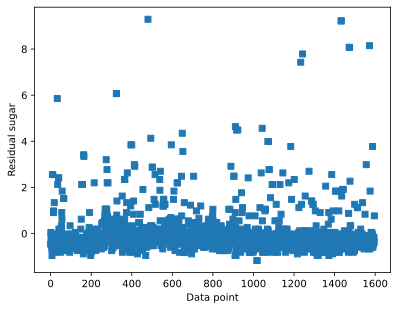

In [36]:
plt.plot(sugar,'s')
plt.xlabel('Data point')
plt.ylabel('Residual sugar')
plt.show()

In [37]:
#split the data
train_dataSK,test_dataSK,train_labelsSK,test_labelsSK=train_test_split(dataT,sugar,test_size=0.1)
#then convert them into Pytorch datasets(note: already converted to tensors)
train_dataDataset = TensorDataset(train_dataSK,train_labelsSK)
test_dataDataset  = TensorDataset(test_dataSK,test_labelsSK)
# finally, translate into dataloader objects
batchsize=32
train_loader = DataLoader(train_dataDataset,batch_size=batchsize,shuffle=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])


In [38]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)

    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)

  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) ) # fully connected
    x = F.relu( self.fc2(x) )
    return self.output(x)

Train The model

In [39]:
# a function that trains the model

# global parameter
numepochs = 1000

def trainTheModel():
  # check if the model has parameters
  if not list(winenet.parameters()):
      raise ValueError("Model does not have any parameters!")

  # loss function and optimizer
  lossfun = nn.MSELoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.01)

  # initialize losses
  trainLoss=torch.zeros(numepochs)
  testLoss=torch.zeros(numepochs)
  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    winenet.train()

    # loop over training data batches
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())


    # and get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)

    # test accuracy
    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    testLoss[epochi] = lossfun(yHat,y).item()

  # function output
  return trainLoss,testLoss

In [40]:
winenet=ANNwine()
trainLoss,testLoss=trainTheModel()

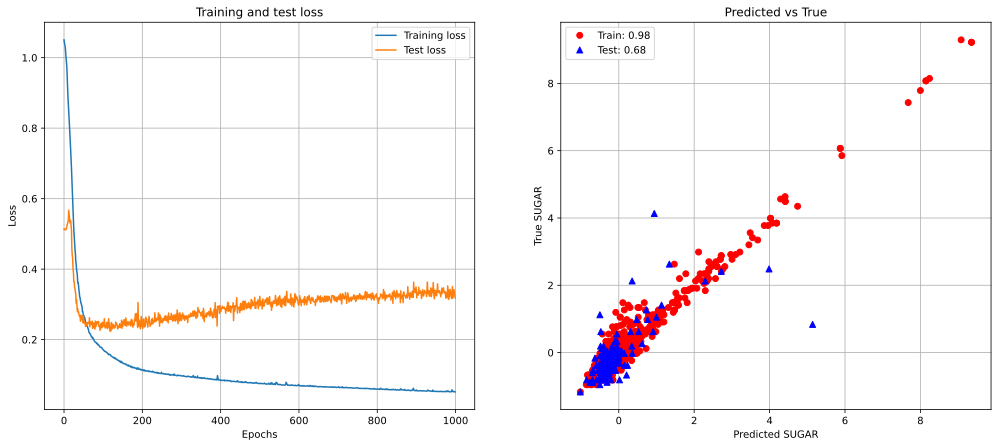

In [41]:
#plot some results
fig,ax=plt.subplots(1,2,figsize=(17,7))
ax[0].plot(trainLoss,label='Training loss')
ax[0].plot(testLoss,label='Test loss')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].grid()
ax[0].set_title('Training and test loss')

#show predictions
yHatTrain=winenet(train_dataSK)
yHatTest=winenet(test_dataSK)
#common feature
ax[1].plot(yHatTrain.detach(),train_labelsSK,'ro')
ax[1].plot(yHatTest.detach(),test_labelsSK,'b^')
ax[1].grid()
ax[1].set_xlabel('Predicted SUGAR')
ax[1].set_ylabel('True SUGAR')
ax[1].set_title('Predicted vs True')
#correlation between predictions adn output
corrTrain=np.corrcoef(yHatTrain.detach().T,train_labelsSK.T)[1,0]
corrTest=np.corrcoef(yHatTest.detach().T,test_labelsSK.T)[1,0]
ax[1].legend(['Train: %.2f'%corrTrain,'Test: %.2f'%corrTest])
plt.show()

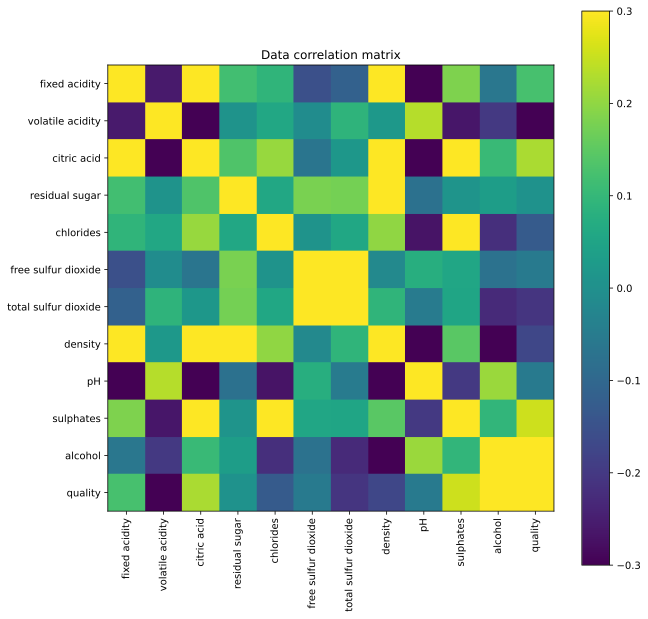

In [42]:
#inspect the correlatation matrix
fig=plt.figure(figsize=(10,10))
plt.imshow(np.corrcoef(data.T),vmin=-.3,vmax=.3)
plt.xticks(range(len(data.keys())),labels=data.keys(),rotation=90)
plt.yticks(range(len(data.keys())),labels=data.keys())
plt.colorbar()
plt.title('Data correlation matrix')
plt.show()
